<a href="https://colab.research.google.com/github/Ahmed2sameh/cnn-lstm/blob/main/Untitled15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator as data_augment
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization,TimeDistributed,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers as layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install split-folders


In [4]:
!ls "/content/drive/My Drive/"


 02a3d43d-53c2-4b37-9d64-6db3ab3c4a56.jpeg  'cv 2024 (1).pdf'
 06A70411-E77C-4CC7-A66B-3754824B55C8.jpeg  'cv 2024.pdf'
 2F1F98C4-9AC5-4FAB-BC2C-7A6663536E57.jpeg  'cv .pdf'
 2fdf456b-de54-400f-8ff3-16c0700601bd.jpeg   D5C67F0B-CFFB-47E4-B642-92AF306B9DE9.jpeg
 3DBD770C-4B37-496F-ADB8-458A5DFC6D85.jpeg   DA25CDDC-BEDF-40A1-BEE8-9335AE660A9B.mov
 4211263				    'face mask data'
 44C66A40-A756-4015-BFA8-953FD1AF8B93.jpeg   face_mask_model.pkl
 4B431618-5801-4AA8-BF6B-CC05A8E588D9.jpeg   face_mask_stage-1.pth
 56A4907C-9DE1-4480-B06B-6AE4188B6D59.jpeg   Files.pdf
 7BCD7110-003D-4A95-9FF0-FB50DD4DBC7F.jpeg  'image (1).jpg'
 951DD47F-2620-4E08-B238-6107B0DED391.jpeg  'image (2).jpg'
 A3843DEE-0F59-4259-80F3-4A1A2F93B2EC.jpeg   image.jpg
 A95CAECB-9DB5-4A78-A4CE-F9C86D4347B3.jpeg  'Inertial Signals'
'ahmed sameh cv (1).pdf'		    'itc video'
'ahmed sameh cv (2).pdf'		    'Menna Mohamed El-Adawy .pdf'
'ahmed sameh cv.pdf'			    'national id (1).pdf'
'CamScanner 12-05-2022 11.48.pdf'	    'natio

In [10]:
import os

dataset_path = "/content/drive/My Drive/cnn-lstm dataset"

files = os.listdir(dataset_path)
print(files[:10])


['.DS_Store', 'drowsky', 'non drowsky']


In [12]:
import splitfolders

data_d = "/content/drive/My Drive/cnn-lstm dataset"

output_d = "/content/splitted_Data"

splitfolders.ratio(data_d, output=output_d, seed=1942, ratio=(.8, .15, .05))

print("Dataset split successfully!")


Copying files: 2548 files [01:00, 42.12 files/s] 

Dataset split successfully!


In [13]:
traind = "/content/splitted_Data/train"
testd = "/content/splitted_Data/test"
vald = "/content/splitted_Data/val"


In [14]:
train_datagen = data_augment(rescale=1./255)
test_datagen = data_augment(rescale=1./255)
val_datagen = data_augment(rescale=1./255)

In [15]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


In [17]:
train_batches = train_datagen.flow_from_directory(
    traind,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
test_batches = test_datagen.flow_from_directory(
    testd,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)
val_batches = val_datagen.flow_from_directory(
    vald,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 2037 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
Found 381 images belonging to 2 classes.


In [18]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'drowsky': 0, 'non drowsky': 1}
Class Counts for train:
 Counter({np.int32(1): 1032, np.int32(0): 1005})

Class Names for test:
 {'drowsky': 0, 'non drowsky': 1}
Class Counts for test:
 Counter({np.int32(1): 66, np.int32(0): 64})

Class Names for validation :
 {'drowsky': 0, 'non drowsky': 1}
Class Counts for validation:
 Counter({np.int32(1): 193, np.int32(0): 188})


Pixels of the first image after Normalization: 

[[[0.6        0.5372549  0.53333336]
  [0.6        0.5372549  0.53333336]
  [0.6        0.5372549  0.53333336]
  ...
  [0.37647063 0.3019608  0.3254902 ]
  [0.37647063 0.30588236 0.33333334]
  [0.3803922  0.30980393 0.34117648]]

 [[0.6        0.53333336 0.5294118 ]
  [0.6        0.5372549  0.53333336]
  [0.6        0.5372549  0.53333336]
  ...
  [0.3803922  0.30980393 0.33333334]
  [0.3803922  0.30980393 0.3372549 ]
  [0.3803922  0.3137255  0.34117648]]

 [[0.59607846 0.53333336 0.52156866]
  [0.6        0.5372549  0.5254902 ]
  [0.6        0.5372549  0.5294118 ]
  ...
  [0.38823533 0.3137255  0.3372549 ]
  [0.38823533 0.3137255  0.34117648]
  [0.38823533 0.3137255  0.34509805]]

 ...

 [[0.5372549  0.5529412  0.61960787]
  [0.5568628  0.57254905 0.6392157 ]
  [0.5764706  0.5921569  0.6627451 ]
  ...
  [0.48235297 0.42352945 0.37647063]
  [0.48235297 0.42352945 0.37647063]
  [0.48235297 0.42352945 0.37254903]]

 [[0.56078434 0.5882353  

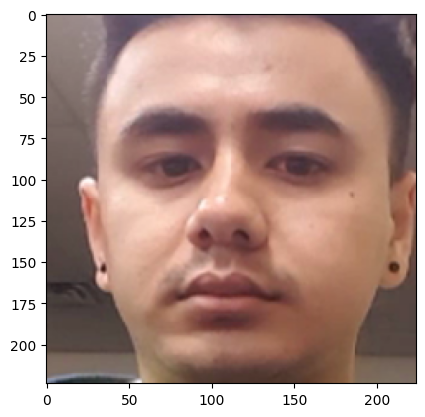

In [19]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

In [20]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")


there are 3 Channels 
image shape : (224, 224, 3)


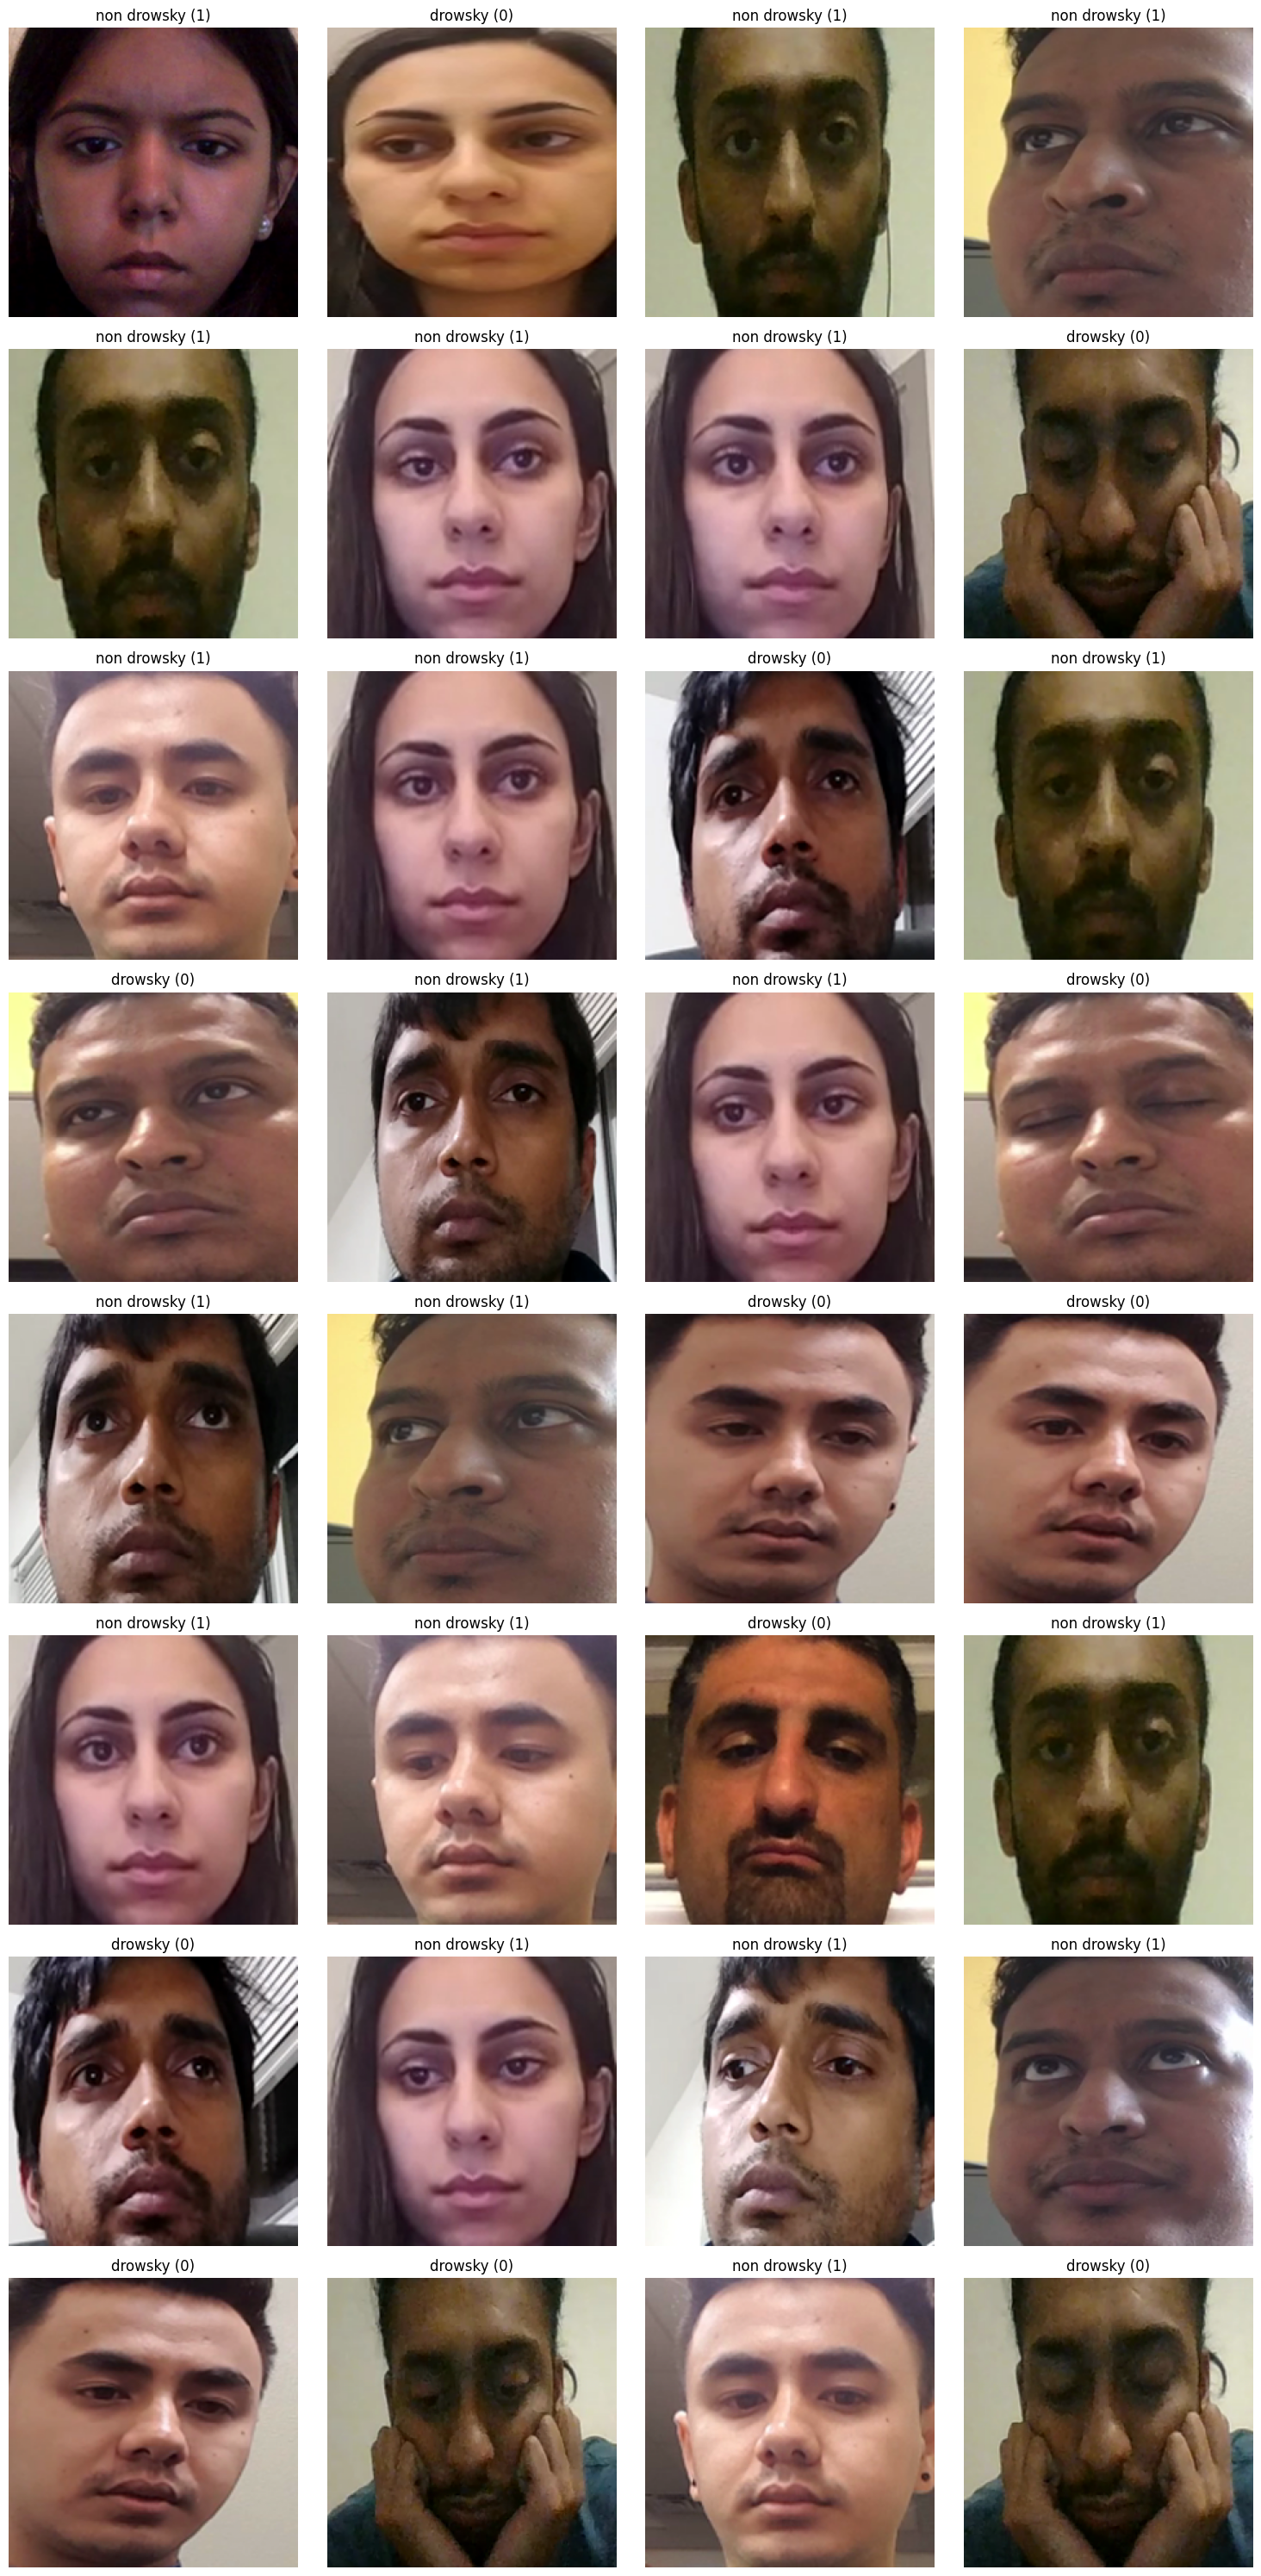

In [21]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [22]:
model_base = keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)
model_base.trainable=False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
model_base.summary()


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [24]:
x = model_base.output
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
preds = Dense(2, activation='softmax')(x)
CNNLSTM = Model(inputs=model_base.input, outputs=preds)


In [25]:
CNNLSTM.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 31,634,946 (120.68 MB)

 Trainable params: 8,070,146 (30.79 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [26]:
CNNLSTM.compile(optimizer=Adam(0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [27]:
history = CNNLSTM.fit(train_batches, epochs = 10, validation_data = val_batches, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.9524 - loss: 0.1928 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 1.0000 - loss: 8.7462e-04 - val_accuracy: 0.9974 - val_loss: 0.0035
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 1.0000 - loss: 4.9026e-04 - val_accuracy: 1.0000 - val_loss: 2.8165e-04
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 1.0000 - loss: 7.4665e-05 - val_accuracy: 1.0000 - val_loss: 2.2992e-04
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 1.0000 - loss: 4.7071e-05 - val_accuracy: 1.0000 - val_loss: 1.9684e-04
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 1.0000 - loss: 3.2828e-05 - val_accuracy: 1.0000 - val_loss: 1.7559e-04
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 1.0000 - loss: 2.3590e-05 - val_accuracy: 1.0000 - val_loss: 1.5645e-04
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - 

In [28]:
train_loss, train_acc = CNNLSTM.evaluate(train_batches)


128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 1.0000 - loss: 8.9239e-06


In [29]:
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")


Training Loss: 0.0000
Training Accuracy: 100.00%


In [30]:
test_loss, test_accuracy = CNNLSTM.evaluate(test_batches)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.2114e-05


In [31]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Loss: 0.0000
Test Accuracy: 100.00%


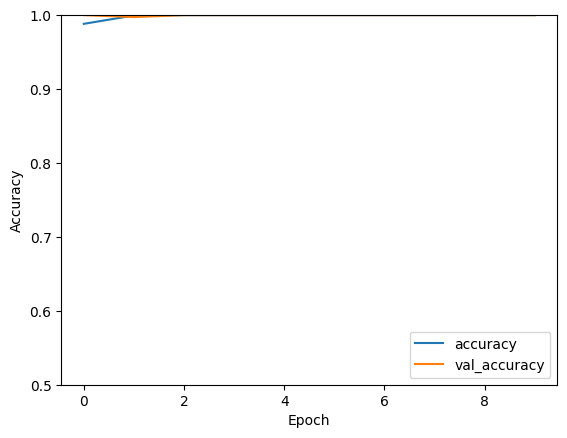

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

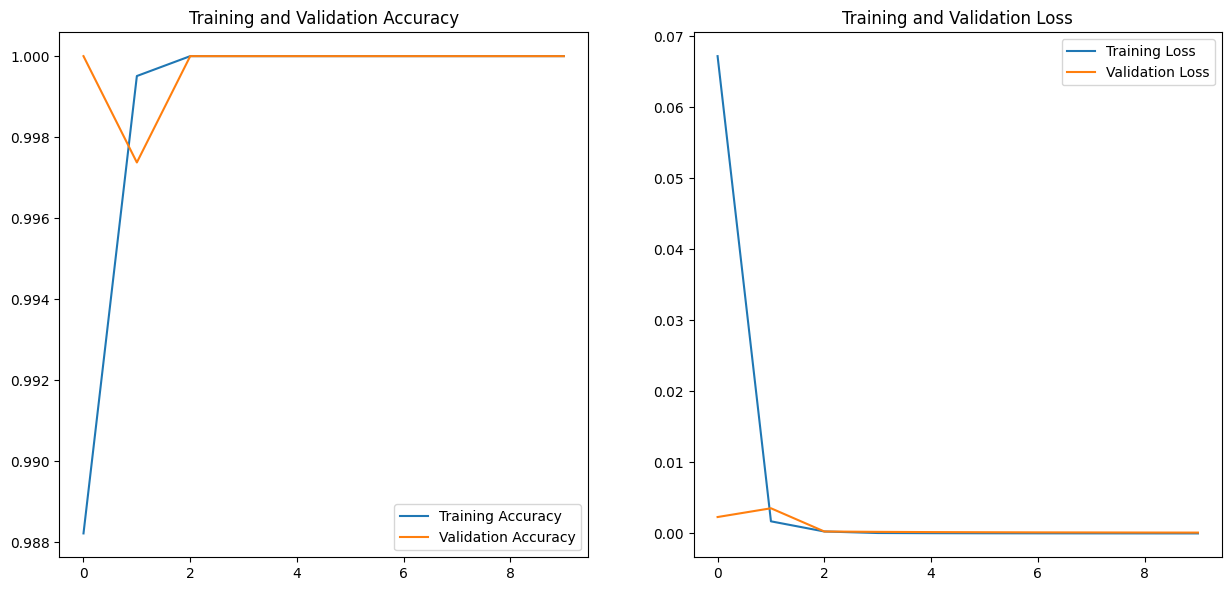

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Text(0, 0.5, 'Loss')

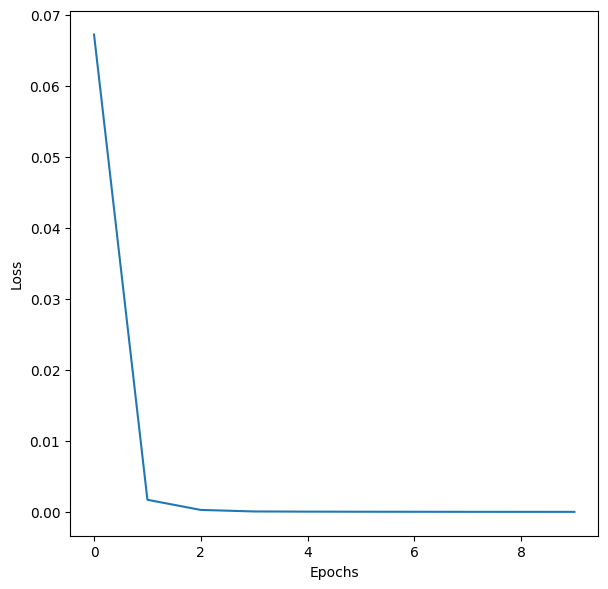

In [34]:
loss = history.history['loss']
epochs_range = range(10)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [35]:
CNNLSTM.save('cnn_lstm1.h5')